In [73]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.svm import SVC
import matplotlib.pyplot as plt

from ND_path_finder.src.data_generators.perlin_generator import PerlinNoiseGenerator
from ND_path_finder.src.data_samplers.random_sampler import sample_xarray
from ND_path_finder.src.edge_detection.SVM_boundary import SVMBoundary

In [143]:
# Initialize the generator with 2D resolution
generator = PerlinNoiseGenerator(res=[100, 100], octv=3, seed=47, time_test=False)

# Generate Perlin noise data
xdataset = generator.perlin_data_xarray()

# generator.plot_2D_xarray()


In [158]:
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import xarray as xr
from numpy.linalg import norm
from scipy.interpolate import interp1d



def svm_boundary_from_xarray(dataset:xr.Dataset, boundary_resolution_len=0.5, boundary_mesh_resolution = 500):
    """
    Fits an SVM model to the data in the xarray.Dataset and plots the decision boundary.

    Parameters:
    - dataset (xarray.Dataset): The input dataset containing 'points' and 'noise_values'.

    Returns:
    - None: Plots the SVM decision boundary and data points.
    """

    # Ensure the required variables are present
    if not {'points', 'noise_values'}.issubset(dataset.variables):
        raise ValueError("Dataset must contain 'points' and 'noise_values' variables.")

    # Extract features and labels
    X = dataset['points'].values  # Shape (num_points, dim)
    y = dataset['noise_values'].values  # Shape (num_points,)


    # Define the parameter grid for grid search
    param_grid = {
        'C': [0.01, 0.1, 1, 5, 10, 100],  # Regularization parameter
        'gamma': [0.001, 0.1, 0.5, 1, 5, 10, 50, 100]  # Kernel coefficient
    }

    # Ensure 2D data for visualization
    if X.shape[1] != 2:
        raise ValueError("This function supports only 2D data (dim=2).")

    # Perform grid search to find the best parameters
    svc = SVC(kernel='rbf')
    grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X, y)

    # Get the best model
    best_svm = grid_search.best_estimator_
    print(f"Best parameters: {grid_search.best_params_}")




    # Create a grid for decision boundary visualization
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, boundary_mesh_resolution),
                        np.linspace(y_min, y_max, boundary_mesh_resolution))

    # Evaluate the decision function
    Z = best_svm.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)



    plt.ioff()  # Turn interactive mode off to suppress showing plots

    # Extract decision boundary points using contour
    contours = plt.contour(xx, yy, Z, levels=[0], linewidths=1, colors="black")
    plt.close()

    # Get all paths
    paths = contours.allsegs[0]  # Get all segments for the contour level


    # List to store interpolated points and gradients
    all_interpolated_points = []

    # Calculate the shortest path length
    path_lengths = []
    for path_segment in paths:
        vertices = np.array(path_segment)
        distances = norm(vertices[1:] - vertices[:-1], axis=1)
        cumulative_distances = np.cumsum(distances)
        cumulative_distances = np.insert(cumulative_distances, 0, 0)
        path_lengths.append(cumulative_distances[-1])  # Total length of the path

    shortest_path_length = min(path_lengths)

    if boundary_resolution_len > shortest_path_length:
        print(f"Boundary resolution length is too large for the shortest path ({shortest_path_length:.3f}). Please reduce the value.")







    # Step 1: Process each segment (path)
    for path_segment in paths:
        vertices = np.array(path_segment)  # Already a NumPy array
        distances = norm(vertices[1:] - vertices[:-1], axis=1)  # Euclidean distances
        cumulative_distances = np.cumsum(distances)
        cumulative_distances = np.insert(cumulative_distances, 0, 0)  # Include starting point

        # Step 2: Interpolate points along the path
        path_length = cumulative_distances[-1]  # Total length of the path
        num_points = int(path_length // boundary_resolution_len) + 1  # Determine number of points based on spacing
        evenly_spaced_distances = np.linspace(0, path_length, num=num_points)

        interp_fn = interp1d(cumulative_distances, vertices, axis=0, kind='linear')
        interpolated_points = interp_fn(evenly_spaced_distances)

        
        # Store points and gradients
        all_interpolated_points.append(interpolated_points)
        
    # Plot the decision boundary and data points
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=5, label="Data Points")
    plus_minus = 0.5
    plt.contour(xx, yy, Z, levels=[-plus_minus,0,plus_minus], linestyles=['-'], colors='k')



    # Plot interpolated points and gradient vectors
    for i, interpolated_points in enumerate(all_interpolated_points):
        plt.plot(interpolated_points[:, 0], interpolated_points[:, 1], 'go', markersize=5, label=f'Boundary Points (Path {i+1})')

    # Add plot details
    plt.title("SVM Decision Boundary with Gradient Vectors")
    plt.xlim(X[:, 0].min(), X[:, 0].max())
    plt.ylim(X[:, 1].min(), X[:, 1].max())
    plt.xlabel("x0")
    plt.ylabel("x1")
    plt.legend()
    plt.show()

Best parameters: {'C': 100, 'gamma': 50}


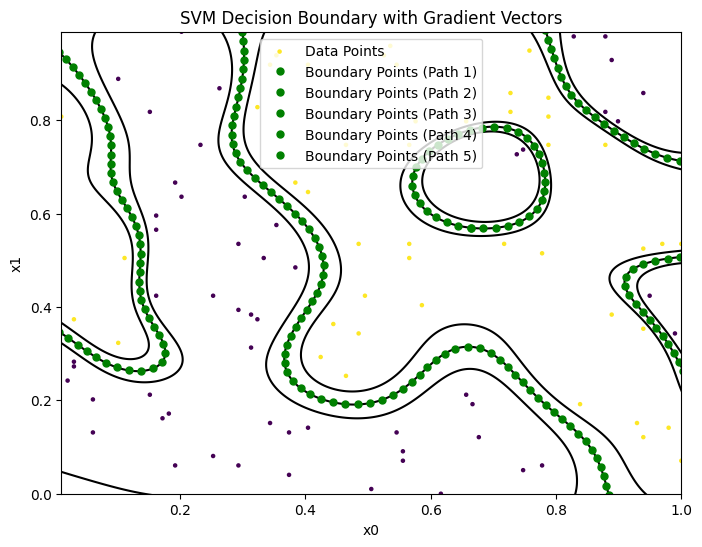

In [160]:
svm_boundary_from_xarray(sample_xarray(xdataset, 100), boundary_resolution_len=0.02)

grid searching... 
searching best svm
found best one
Best parameters: {'C': 10, 'gamma': 10}
200
Length of boundary points (grid-based): 200
Found 2 boundaries.


C:\Users\mcthu\PycharmProjects\ND_path_finder\src\edge_detection\SVM_boundary.py:206: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, Z, levels=[0], linestyles=['-'], colors='k', label="Decision Boundary")


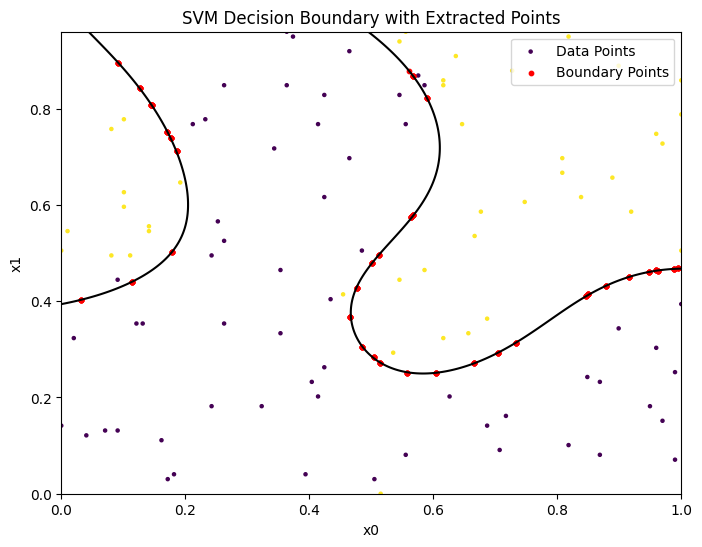

In [4]:
SVMBoundary(sample_xarray(xdataset, 100), num_boundary_points=200).plot_svm_boundary()

# SVMBoundary.xdataset

grid searching... 
searching best svm
found best one
Best parameters: {'C': 100, 'gamma': 100}
100
Length of boundary points (grid-based): 100
Found 10 boundaries.


C:\Users\joesc\git\ND_path_finder\src\edge_detection\SVM_boundary.py:205: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, Z, levels=[0], linestyles=['-'], colors='k', label="Decision Boundary")


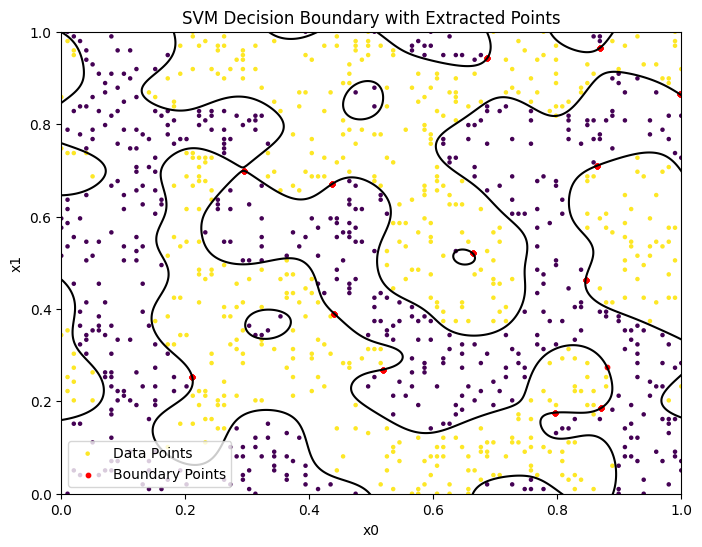

In [5]:
SVMBoundary(sample_xarray(xdataset, 1000)).plot_svm_boundary()



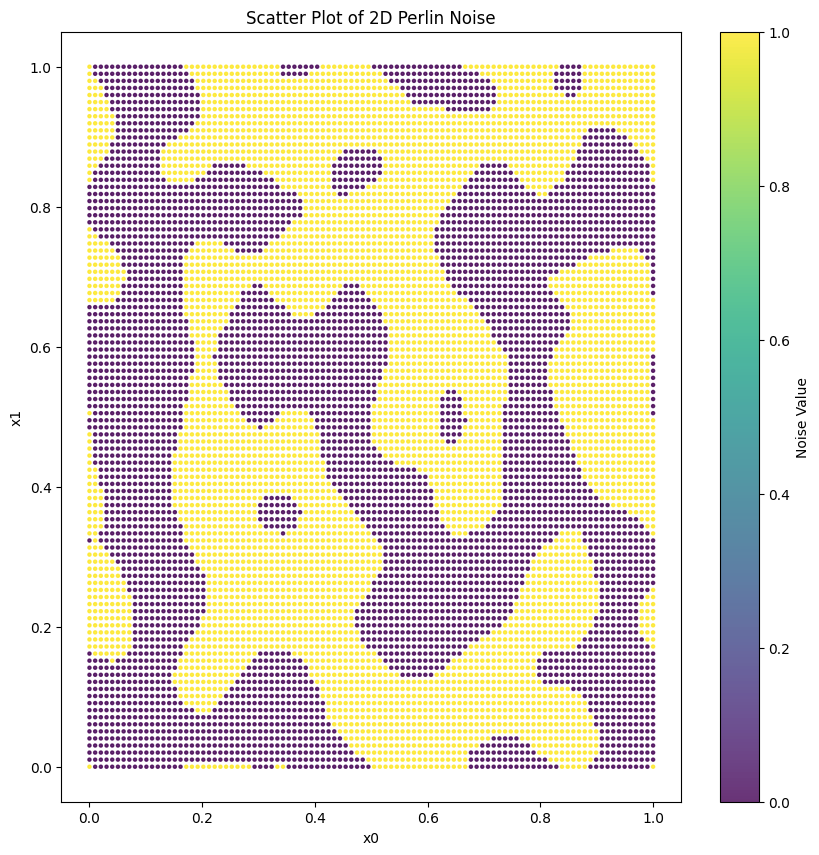

In [119]:

generator.plot_2D_xarray()

grid searching... 
searching best svm
found best one
Best parameters: {'C': 100, 'gamma': 100}
100
Length of boundary points (grid-based): 100
Found 6 boundaries.


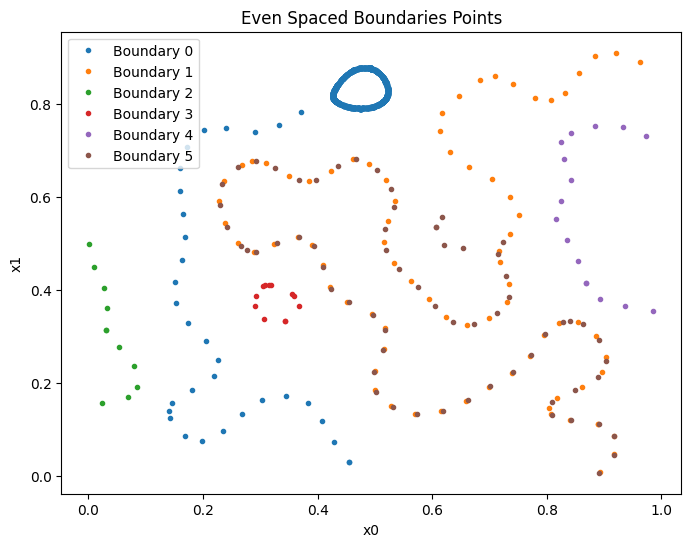

In [7]:
# Plot the identified boundaries
SVMBoundary(sample_xarray(xdataset, 1000)).plot_traversed_boundaries()